# Predictin Diamond Prices

**Objective:** Build a model that will predict price for each record, given an input file with the same layout as diamonds.txt minus price.

- **Data:** Tab delimited text file with header and 40,000 records of **“round”** diamonds 
- **Price:** in US dollars
- **Cut:** quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- **Color:** diamond color, from J (worst) to D (best)
- **Clarity:** a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- **Depth:** total depth percentage = z / mean(x, y) = 2 * z / (x + y)
- **Table:** width of top of diamond relative to widest point
- **X:** length in mm 
- **Y:** width in mm 
- **Z:** depth in mm 

## Obtain Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import statsmodels.api as sm

In [2]:
df = pd.read_csv('diamonds.txt', sep = '\t')
df.head()

,price,cut,color,clarity,depth,table,x,y,z
0,326,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
1,335,Good,J,SI2,63.3,58.0,4.34,4.35,2.75
2,336,Very Good,J,VVS2,62.8,57.0,3.94,3.96,2.48
3,336,Very Good,I,VVS1,62.3,57.0,3.95,3.98,2.47
4,337,Very Good,H,SI1,61.9,55.0,4.07,4.11,2.53


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
price      40000 non-null int64
cut        40000 non-null object
color      40000 non-null object
clarity    40000 non-null object
depth      40000 non-null float64
table      40000 non-null float64
x          40000 non-null float64
y          40000 non-null float64
z          40000 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 2.7+ MB


## Clean/Explore Data

In [4]:
# says there are 40,000 non-null values but let's do a sanity check
df.isna().any()

price      False
cut        False
color      False
clarity    False
depth      False
table      False
x          False
y          False
z          False
dtype: bool

There are no null values so now let's check the distributions of the features.

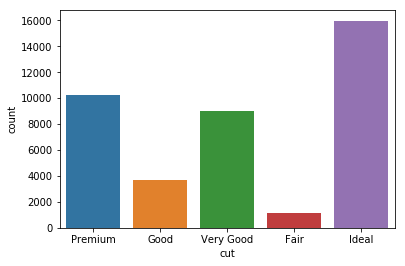

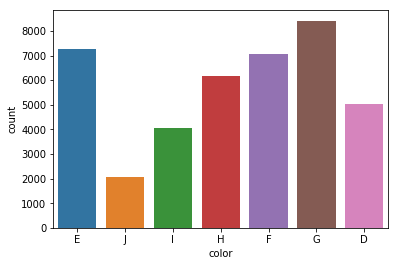

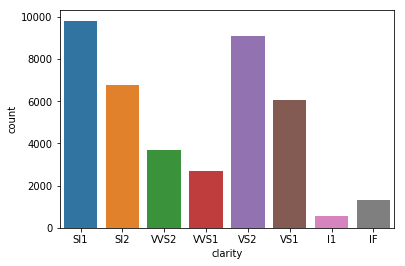

In [5]:
# Check categorical features
cat_cols = ['cut', 'color', 'clarity']
for col in cat_cols:
    sns.countplot(df[col])
    plt.show()

The categorical features look fine, now let's check the numerical features.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,40000.0,3938.823200,3991.590829,326.0,947.75,2416.00,5351.00,18823.00
depth,40000.0,61.741918,1.425448,43.0,61.00,61.80,62.50,79.00
table,40000.0,57.462855,2.238584,43.0,56.00,57.00,59.00,95.00
x,40000.0,5.732488,1.121778,0.0,4.71,5.70,6.54,10.74
y,40000.0,5.735252,1.121122,0.0,4.72,5.71,6.54,31.80
z,40000.0,3.538651,0.694769,0.0,2.91,3.53,4.04,6.98


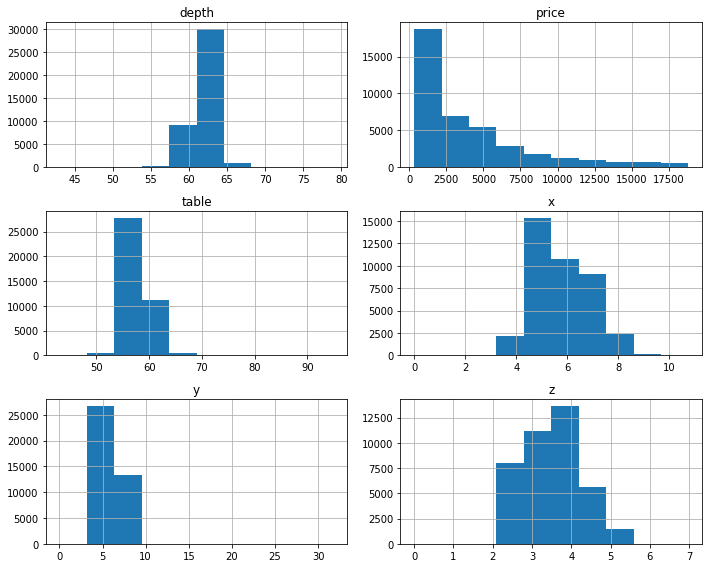

In [7]:
df.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

Some very obvious skew with the target variable, 'price'. Can log transform and decide later on which target variable to use. Also there seem to be some odd values for 'x', 'y', and 'z' with them having minimum values of 0 in some cases. I am not a diamond expert but that seems odd. Let's check how many of these rows have these outliers.

In [8]:
for col in ['x', 'y', 'z']:
    print('Number of rows where {} = {}'.format(col, (df[col] == 0).sum()))

Number of rows where x = 6
Number of rows where y = 5
Number of rows where z = 14


In [9]:
df[['x','y','z']] = df[['x','y','z']].replace(0, np.NaN)
len(df.dropna()) - len(df)

-14

14 rows out of 40000 won't make much of a difference so we can drop these rows.

In [10]:
df.dropna(inplace=True)

## Feature Engineering

In [11]:
# log transform target variable 'price' since it is skewed
df['log_price'] = np.log(df.price)

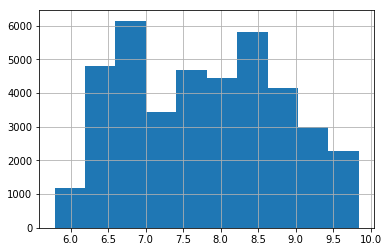

In [12]:
df.log_price.hist()
plt.show()

The distribution for price after being log transformed looks much better to be applied to modeling.
<br>

One feature that I believe would be important is to calculate the carat for each diamond.  According to this [link](https://www.jewelrynotes.com/how-to-measure-round-diamonds/), since all the diamonds in the dataset are "round" diamonds, we can use the formula 
<br>

$carat$ = $(girdleDiameter^{2})$ $(z)$ $(0.006)$ 
<br>

And the girdle diameter can be found by taking $mean(x, y)$

In [13]:
# create g_diameter feature
df['g_diameter'] = (df.x + df.y)/2

In [14]:
# create carat feature
df['carat'] = np.round(df.g_diameter**2*df.z*0.006, 2)

In [15]:
df.head()

,price,cut,color,clarity,depth,table,x,y,z,log_price,g_diameter,carat
0,326,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,5.786897,3.865,0.21
1,335,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,5.814131,4.345,0.31
2,336,Very Good,J,VVS2,62.8,57.0,3.94,3.96,2.48,5.817111,3.950,0.23
3,336,Very Good,I,VVS1,62.3,57.0,3.95,3.98,2.47,5.817111,3.965,0.23
4,337,Very Good,H,SI1,61.9,55.0,4.07,4.11,2.53,5.820083,4.090,0.25


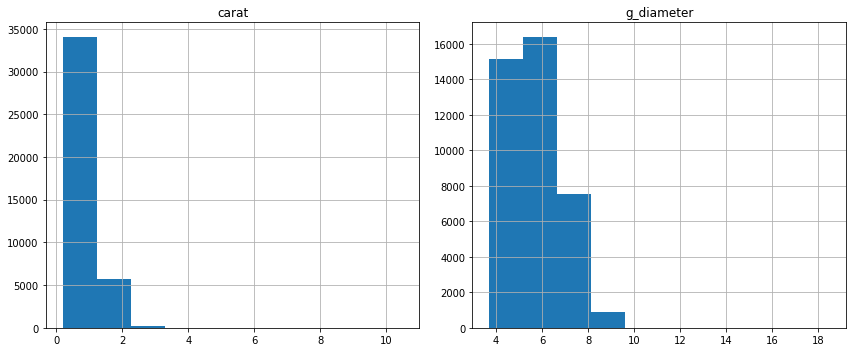

In [16]:
df[['g_diameter', 'carat']].hist(figsize=(12,5))
plt.tight_layout()
plt.show()

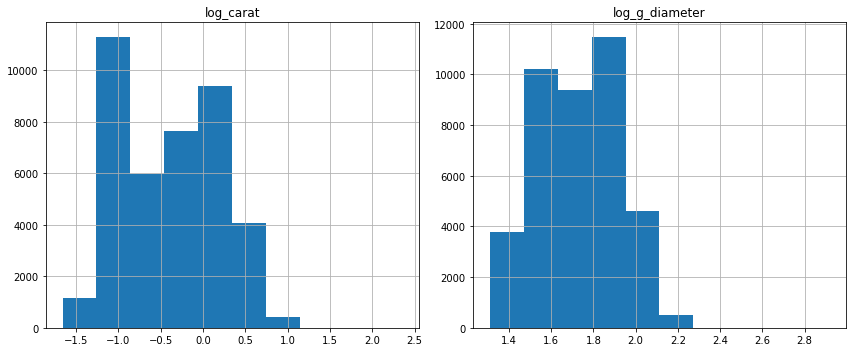

In [17]:
# log transform newly engineered features due to skew
df['log_g_diameter'] = np.log(df.g_diameter)
df['log_carat'] = np.log(df.carat)

df[['log_g_diameter', 'log_carat']].hist(figsize=(12,5))
plt.tight_layout()
plt.show()

## Check for Collinearity

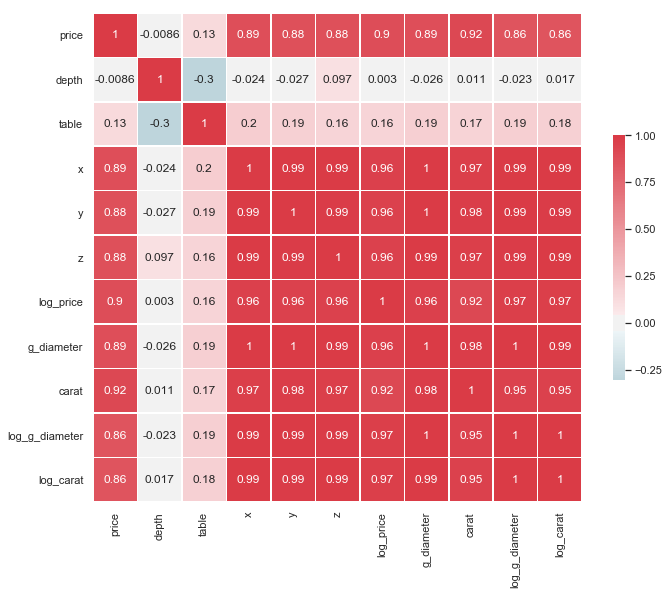

In [18]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

From the heatmap above, can see that price correlates strongly to all the features except 'depth' and 'table'. There is also obvious collinearity between many of the features. 
<br>

Now let's just double check for collinearity after getting our dummy variables for the categorical features.

In [19]:
dummy_df = pd.get_dummies(df, drop_first=True)
dummy_df.head()

,price,depth,table,x,y,z,log_price,g_diameter,carat,log_g_diameter,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,326,59.8,61.0,3.89,3.84,2.31,5.786897,3.865,0.21,1.351962,...,0,0,0,0,1,0,0,0,0,0
1,335,63.3,58.0,4.34,4.35,2.75,5.814131,4.345,0.31,1.469026,...,0,0,1,0,0,1,0,0,0,0
2,336,62.8,57.0,3.94,3.96,2.48,5.817111,3.950,0.23,1.373716,...,0,0,1,0,0,0,0,0,0,1
3,336,62.3,57.0,3.95,3.98,2.47,5.817111,3.965,0.23,1.377506,...,0,1,0,0,0,0,0,0,1,0
4,337,61.9,55.0,4.07,4.11,2.53,5.820083,4.090,0.25,1.408545,...,1,0,0,0,1,0,0,0,0,0


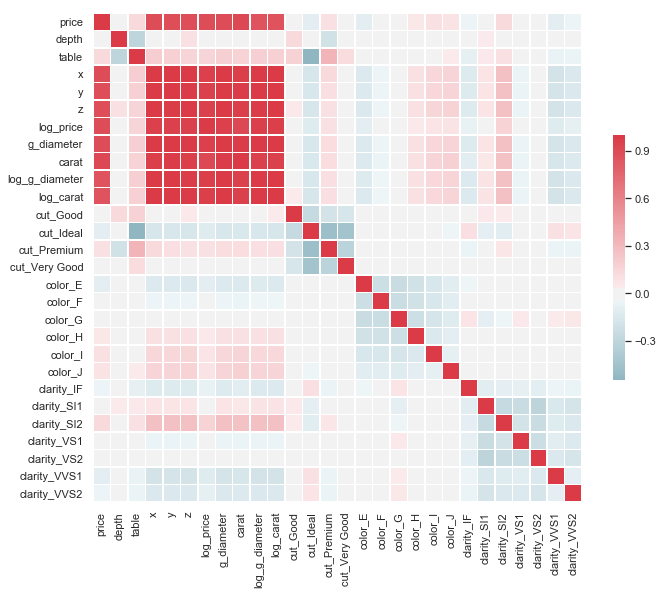

In [20]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = dummy_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False);

Appears that collinearity with the dummy variables isn't an issue.
<br>

Since 'x', 'y', and 'z' have high collinearity to the engineered features, and these engineered features have a stronger relation with 'price', we will drop them. I will also drop the features used for log transformations.

In [21]:
# Create final dataFrame for modeling
final_df = dummy_df.drop(['x', 'y', 'z', 'price', 'g_diameter', 'carat'], axis=1)
final_df.head()

,depth,table,log_price,log_g_diameter,log_carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,59.8,61.0,5.786897,1.351962,-1.560648,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,63.3,58.0,5.814131,1.469026,-1.171183,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,62.8,57.0,5.817111,1.373716,-1.469676,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,62.3,57.0,5.817111,1.377506,-1.469676,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,61.9,55.0,5.820083,1.408545,-1.386294,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0


## Split and Scale Data for Modeling

In [22]:
# Set target variable
X = final_df.drop('log_price', axis=1)
y = final_df.log_price

In [23]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Normalize the data but only fit on the training set to avoid leakage into the test set
# I find that Normalizer is usually better for regression problems when StandardScaler is better for classification
normalize = Normalizer()
X_train = pd.DataFrame(normalize.fit_transform(X_train), columns=list(X_train.columns))
X_test = pd.DataFrame(normalize.transform(X_test), columns=list(X_test.columns))
X_train.head()

,depth,table,log_g_diameter,log_carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.743898,0.667601,0.017690,-0.013584,0.0,0.011921,0.0,0.000000,0.011921,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.011921
1,0.732698,0.679943,0.016104,-0.017229,0.0,0.000000,0.0,0.011723,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.011723,0.000000
2,0.736372,0.675897,0.017433,-0.013888,0.0,0.011858,0.0,0.000000,0.000000,0.011858,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.011858,0.000000,0.000000
3,0.745579,0.665696,0.017891,-0.014175,0.0,0.012104,0.0,0.000000,0.000000,0.012104,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.012104,0.000000
4,0.728329,0.684653,0.022497,0.001443,0.0,0.000000,0.0,0.011804,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.011804,0.0,0.0,0.000000,0.000000,0.000000


## Modeling

Now that the data is ready for modeling, I will use a simple Linear Regression model since it is a pretty simple yet effective model and also is easy to interpret. 

### Model 1 (Linear Regression ScikitLearn)

In [26]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Training R Squared = 0.9805670964531191
Test R Squared = 0.9817329533258207
Training MSE = 0.0200964936590925
Test MSE = 0.018761930022165037
Training average cv score = 0.9804893187943673
Test average cv score = 0.9816594384332091


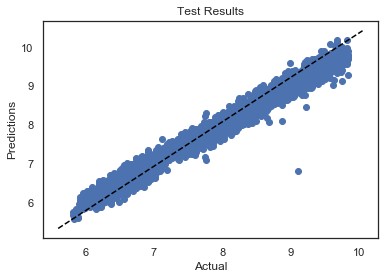

In [27]:
# Get train/test predictions
train_linreg_y_preds = linreg.predict(X_train)
train_r2 = linreg.score(X_train, y_train)

# Get train/test R Squared values
test_linreg_y_preds = linreg.predict(X_test)
test_r2 = linreg.score(X_test, y_test)
print('Training R Squared =', train_r2)
print('Test R Squared =', test_r2)

# Get train/test MSE values
train_mse = mean_squared_error(y_train, train_linreg_y_preds)
test_mse = mean_squared_error(y_test, test_linreg_y_preds)
print('Training MSE =', train_mse)
print('Test MSE =', test_mse)

# Get train/test cross_val scores
train_cv_results_5 = cross_val_score(linreg, X_train, y_train, cv = 5, scoring='r2')
test_cv_results_5 = cross_val_score(linreg, X_test, y_test, cv=5, scoring='r2')
print('Training average cv score =', np.mean(train_cv_results_5))
print('Test average cv score =', np.mean(test_cv_results_5))

# Plot Test results
plt.scatter(y_test, test_linreg_y_preds)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.title('Test Results')
plt.plot(plt.xlim(), plt.ylim(), color='black', linestyle='--');

An R Squared of about 98% is very good and means that about 98% of the variance in 'log_price' can be explained by the regression model. These scores are very acceptable and there doesn't seem to be overfitting due to the test scores and cross val scores being very similar to the training scores.
<br>

Now I will just take a look at the Linear Regression model using StatsModels to see if there are any features that can be eliminated due to their p-value.

### Model 2 (Linear Regression StatsModels)

In [28]:
# Set target variable
X = final_df.drop('log_price', axis=1)
y = final_df.log_price

In [29]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Normalize the data but only fit on the training set to avoid leakage into the test set
normalize = Normalizer()
X_train = pd.DataFrame(normalize.fit_transform(X_train), columns=list(X_train.columns))
X_test = pd.DataFrame(normalize.transform(X_test), columns=list(X_test.columns))
y_train = list(y_train) # needed to get feature names to show up in the summary
X_train.head()

,depth,table,log_g_diameter,log_carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.743898,0.667601,0.017690,-0.013584,0.0,0.011921,0.0,0.000000,0.011921,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.011921
1,0.732698,0.679943,0.016104,-0.017229,0.0,0.000000,0.0,0.011723,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.011723,0.000000
2,0.736372,0.675897,0.017433,-0.013888,0.0,0.011858,0.0,0.000000,0.000000,0.011858,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.011858,0.000000,0.000000
3,0.745579,0.665696,0.017891,-0.014175,0.0,0.012104,0.0,0.000000,0.000000,0.012104,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.012104,0.000000
4,0.728329,0.684653,0.022497,0.001443,0.0,0.000000,0.0,0.011804,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.011804,0.0,0.0,0.000000,0.000000,0.000000


In [31]:
X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train).fit()
train_predictions = model.predict(X_train)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 7.681e+04
Date:                Mon, 19 Aug 2019   Prob (F-statistic):               0.00
Time:                        23:39:47   Log-Likelihood:                 17103.
No. Observations:               31988   AIC:                        -3.416e+04
Df Residuals:                   31966   BIC:                        -3.398e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.5606      1.570     -1.

The R Squared for this model is very similar to the Scikit-Learn model and it doesn't look like there are any obvious features that could be removed.  For simplicity, I will now make a model using the two features that were engineered since they seemed to have the strongest relationship with the target variable.

### Model 3 (Linear Regression Scikit-Learn after feature reduction)

In [32]:
# Set target variable
X = final_df[['log_g_diameter', 'log_carat']]
y = final_df.log_price

In [33]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Normalize the data but only fit on the training set to avoid leakage into the test set
normalize = Normalizer()
X_train = pd.DataFrame(normalize.fit_transform(X_train), columns=list(X_train.columns))
X_test = pd.DataFrame(normalize.transform(X_test), columns=list(X_test.columns))
X_train.head()

,log_g_diameter,log_carat
0,0.793142,-0.609036
1,0.682854,-0.730555
2,0.782154,-0.623085
3,0.783801,-0.621012
4,0.997950,0.063997


In [35]:
linreg2 = linear_model.LinearRegression()
linreg2.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Training R Squared = 0.9368309330731286
Test R Squared = 0.9390186358815659
Training MSE = 0.06532614901752146
Test MSE = 0.06263344626274295
Training average cv score = 0.9368019117387261
Test average cv score = 0.939005301681291


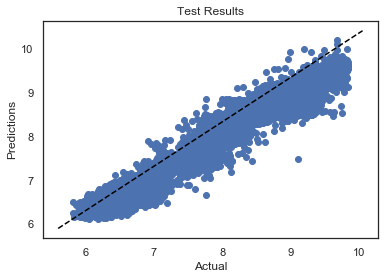

In [36]:
# Get train/test predictions
train_linreg_y_preds = linreg2.predict(X_train)
train_r2 = linreg2.score(X_train, y_train)

# Get train/test R Squared values
test_linreg_y_preds = linreg2.predict(X_test)
test_r2 = linreg2.score(X_test, y_test)
print('Training R Squared =', train_r2)
print('Test R Squared =', test_r2)

# Get train/test MSE values
train_mse = mean_squared_error(y_train, train_linreg_y_preds)
test_mse = mean_squared_error(y_test, test_linreg_y_preds)
print('Training MSE =', train_mse)
print('Test MSE =', test_mse)

# Get train/test cross_val scores
train_cv_results_5 = cross_val_score(linreg2, X_train, y_train, cv = 5, scoring='r2')
test_cv_results_5 = cross_val_score(linreg2, X_test, y_test, cv=5, scoring='r2')
print('Training average cv score =', np.mean(train_cv_results_5))
print('Test average cv score =', np.mean(test_cv_results_5))

# Plot Test results
plt.scatter(y_test, test_linreg_y_preds)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.title('Test Results')
plt.plot(plt.xlim(), plt.ylim(), color='black', linestyle='--');

In [37]:
print('intercept =', linreg2.intercept_)
print('variable coefficients =', linreg2.coef_)

intercept = 8.666457467168637
variable coefficients = [-0.13177152  3.29015089]


## Conclusion



Although R Squared drops by about 4-5%, this model is a lot simpler to interpret since it only uses two features. For example, the coefficient for log_carat is about 3.29.  Since both this feature and the target variable were log transformed, this coefficient means that for every 1% increase in 'carat', leads to about a 3.29% increase in 'price'. 

## Future Work

Overall I'm very satisfied with the findings and the end models. Given the amount of time meant to spend on this project there is definitely a lot more that could have been done such as:
- Test different machine learning models
- Do a more deliberate recursive feature elimination (RFE)
- Explore the data more to further domain knowledge and look for trends
- Compare models using different scaling or against the target variable without being log transformed